In [50]:
##### from __future__ import division
from re import compile, match


category_re = compile(r'^(?P<prefix>[^ ]{4})[^ ]*:$')
accuracy_re = compile(r'^ACCURACY TOP1:.*\((?P<successes>[0-9]*) / (?P<attempts>[0-9]*)\)$')
veclen_re = compile(r'^\[INFO\] Current vec len (?P<veclen>[0-9]*):$')

total_accs = dict()
basepath = '/var/tmp/xstefan3/vectors/accuracies/' 
pathnames = ['acc_1b_pca_600_to_x_f.log', 'acc_1b.log', 'acc_1b_sparsepca_600_to_X_f.log', 
             'acc_32b.log', 'acc_32b_pca_600_to_x.log',
             'acc_0b.log', 'acc_0b_pca_600_to_x.log']

for log_pathname in pathnames:
    counters = {
        'semantic': {
            'successes': 0,
            'attempts': 0,
            'accuracies': {},
        },
        'syntactic': {
            'successes': 0,
            'attempts': 0,
            'accuracies': {},
        },
        'total': {
            'successes': 0,
            'attempts': 0,
            'accuracies': {},
        }
    }
    with open(basepath+log_pathname, 'rt') as f:
        current_category_type = None
        current_veclen = None        
        for line in f.readlines():

            veclen_match = match(veclen_re, line)
            if veclen_match:
                if current_veclen is not None:
                    for category_type in 'semantic', 'syntactic', 'total':
                        successes = counters[category_type]['successes']
                        attempts = counters[category_type]['attempts']
                        if attempts > 0:
                            accuracy = successes / attempts * 100.0
                        else:
                            accuracy = 0.0
                        counters[category_type]['accuracies'][current_veclen] = accuracy
                        counters[category_type]['successes'] = 0
                        counters[category_type]['attempts'] = 0
                current_veclen = int(veclen_match.group('veclen'))

            category_match = match(category_re, line)
            if category_match:
                if category_match.group('prefix') == 'gram':
                    current_category_type = 'syntactic'
                else:
                    current_category_type = 'semantic'

            accuracy_match = match(accuracy_re, line)
            if accuracy_match:
                assert current_category_type is not None
                for category_type in current_category_type, 'total':
                    for counter_type in 'successes', 'attempts':
                        counters[category_type][counter_type] += int(accuracy_match.group(counter_type))

    total_accs[log_pathname] = counters['total']['accuracies']

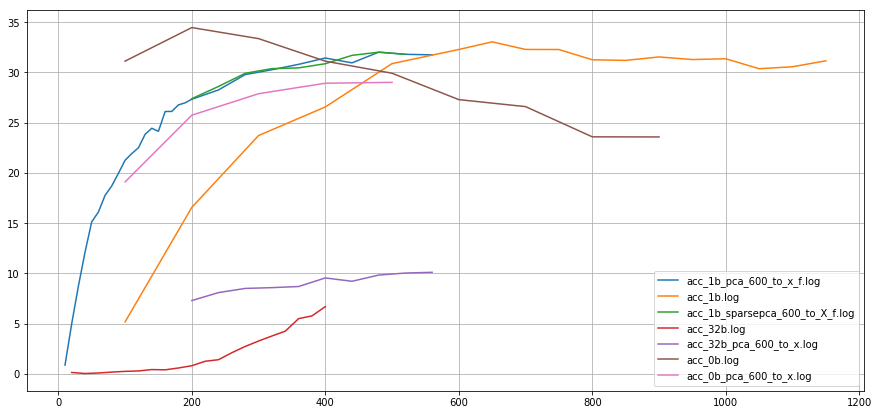

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt

# detail of dimensions below 200
plt.figure(figsize=(15, 7))
for pname in pathnames:
    plt.plot(*zip(*sorted(total_accs[pname].items())))
    
plt.legend(pathnames)
plt.grid(True)